In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
device = "cpu"

import yaml
import os
cfg_path = "checkpoints/final_model2/config_local.yaml"

with open(cfg_path) as f:
    cfg = yaml.safe_load(f)

cfg["device"] = device
cfg["model"]["patchify_args"]["device"] = device
cfg["model"]["unpatchify_args"]["device"] = device

from src.utils import load_model_from_config

model = load_model_from_config(cfg)

# Find and load last epoch in the directory
dir = os.path.join(cfg["training"]["checkpoint_dir"], "model")
last_epoch = max([int(f.split("_")[1].removesuffix(".pth")) for f in os.listdir(dir) if f.startswith("epoch_")], default=0)
model.load_model(os.path.join(dir, f"epoch_{last_epoch}.pth"))
print(last_epoch)

model.eval()

/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


10


ALMTokenizer(
  (query_encoder): QueryEncoder(
    (layers): ModuleList(
      (0-11): 12 x RopeEncoderLayer(
        (q_proj): Linear(in_features=128, out_features=128, bias=False)
        (k_proj): Linear(in_features=128, out_features=128, bias=False)
        (v_proj): Linear(in_features=128, out_features=128, bias=False)
        (out_proj): Linear(in_features=128, out_features=128, bias=False)
        (rope): RotaryPositionalEmbeddings()
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=256, out_features=128, bias=True)
        )
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (query_decoder): QueryEncoder(
    (layers): ModuleList(
      (0-11): 12 x RopeEncoderLayer(
        (q_proj): Linear(in_features=128, out_features=128, bias=False)
        (k_proj

### Generate the embeddings

In [51]:
from src.datasets import GoodSoundsDataset



dataset = GoodSoundsDataset(root_dir="../good_sounds_dataset",
                            db_filename="good-sounds/database.sqlite")

from utils import save_codes_h5

save_codes_h5(
    dataset=dataset,
    model=model.eval(),
    h5_path="codes/good_sounds2.h5",
    device=device
)

100%|██████████| 16308/16308 [07:52<00:00, 34.55it/s] 

Saved codes and metadata for 16308 samples to codes/good_sounds2.h5


### Structure the data

In [3]:
import h5py
from tqdm import tqdm
import torch

z = list()
z_attrs = list()

h = list()
h_attrs = list()

with h5py.File("codes/good_sounds2.h5", 'r') as f:
    # Get the mean of each sample's codes
    for i, key in tqdm(enumerate(f.keys())):
        grp = f[key]

        keys = ["sound_id", "instrument", "note", "octave", "klass"]
        res_dict = dict()
        for key in keys:
            res_dict[key] = grp.attrs.get(key, "unknown")
        try:
            z_mat = grp["z_level_0"][:].T
            if z_mat.ndim == 1:
                z_mat = z_mat[torch.newaxis, :]
            z_attrs += [res_dict] * z_mat.shape[0]
            z.append(z_mat)

            h_mat = grp["h_level_0"][:]
            if h_mat.ndim == 1:
                h_mat = h_mat[torch.newaxis, :]
            h_attrs += [res_dict] * h_mat.shape[0]
            h.append(h_mat)
        except Exception as e:
            print(f"Error processing group {key}: {e}")

2705it [00:02, 975.03it/s] 


In [4]:
import numpy as np
z_res = np.vstack(z)
h_res = np.vstack(h)

In [5]:
import gc
del z
del h
gc.collect()

31

In [6]:
import pandas as pd

z_attributes = pd.DataFrame(z_attrs)
h_attributes = pd.DataFrame(h_attrs)
X = pd.concat([pd.DataFrame(z_res), pd.DataFrame(h_res)], keys=["EnCodec", "ALMTokenizer"])
df = pd.concat([z_attributes, h_attributes], keys=["EnCodec", "ALMTokenizer"])

### Define the labels

In [7]:
# Transform labels to integer indices
from sklearn.preprocessing import LabelEncoder

def generate_label_encoder(df, keys):
    encoders = dict()
    num_labels = df.copy()
    for key in keys:
        le = LabelEncoder()
        le.fit(df[key])
        encoders[key] = le
        num_labels[key] = le.transform(df[key])
    return encoders, num_labels

def get_good_bad(label: str) -> str:
    if not label or label.strip() == "":
        return "other"
    if "good" in label:
        return "good"
    if "bad" in label:
        return "bad"
    return "other"

df["klass"] = df["klass"].apply(get_good_bad)
attributes = ["instrument", "note", "octave", "klass"]
label_encoders, num_labels = generate_label_encoder(df, attributes)

/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

def stratified_sample(df, source_col="source", n=100, group_cols=("instrument", "note", "octave", "klass"), random_state=0):
    df = df.copy()
    # Create a combined label for stratification
    
    sample_indices = []
    for src, d in df.groupby(level=0):
        strata = d[list(group_cols)].astype(str).agg("_".join, axis=1)
        # If not enough rows, just take all
        n_target = min(n, len(d))
        if n_target == len(d):
            sample_indices += d
        else:
            # Stratified downsample
            s, _ = train_test_split(
                d, train_size=n_target, 
                stratify=strata, 
                random_state=random_state
            )
            sample_indices += s.index.tolist()

    return sample_indices

In [9]:
indices = stratified_sample(
    df, 
    source_col="source",
    n=1000,
    group_cols=("instrument", "note"),
    random_state=123
)


In [10]:
df_subset = df.loc[indices]
x_subset = X.loc[indices]
num_labels_subset = num_labels.loc[indices]

In [11]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt
from matplotlib import cm

def projection(x, labels_df, columns, proj_fn=TSNE, y=None, legend=False, proj_fn_kwargs={}, transform_kwargs={}, plot_kwargs={}):

    proj = proj_fn(**proj_fn_kwargs)
    
    
    if y is None:
        coords = proj.fit_transform(x, **transform_kwargs)

    fig, axs = plt.subplots(1, len(columns), figsize=(20, 5))
    try:
        axs = axs.flatten()
    except AttributeError:
        axs = [axs]

    labels = labels_df
    for ax, key in zip(axs, columns):
        if y is not None:
            y_grp = y[key]
            coords = proj.fit_transform(x, y_grp, **transform_kwargs)
        colors = cm.get_cmap("tab10", len(labels_df[key].unique()))
        for label, c in zip(labels_df[key].unique(), colors.colors.tolist()):
            # Get coordinates for the current label
            grp_coords = coords[labels[key] == label]
            ax.scatter(grp_coords[:, 0], grp_coords[:, 1], color=c, s=1.5, cmap="tab10", label=label)
        ax.set_title(key)
        xlabel = plot_kwargs.get("xlabel", "Axis 1")
        ax.set_xlabel(xlabel)

        ylabel = plot_kwargs.get("ylabel", "Axis 2")
        ax.set_ylabel(ylabel)

        if legend:
            ax.legend(loc='upper right', fontsize='small', markerscale=2, ncol=2)
        ax.set_aspect("equal")

    if "suptitles" in plot_kwargs:
        suptitle = plot_kwargs["suptitles"]
        fig.suptitle(suptitle, fontsize=16, y=1.1)
    return fig



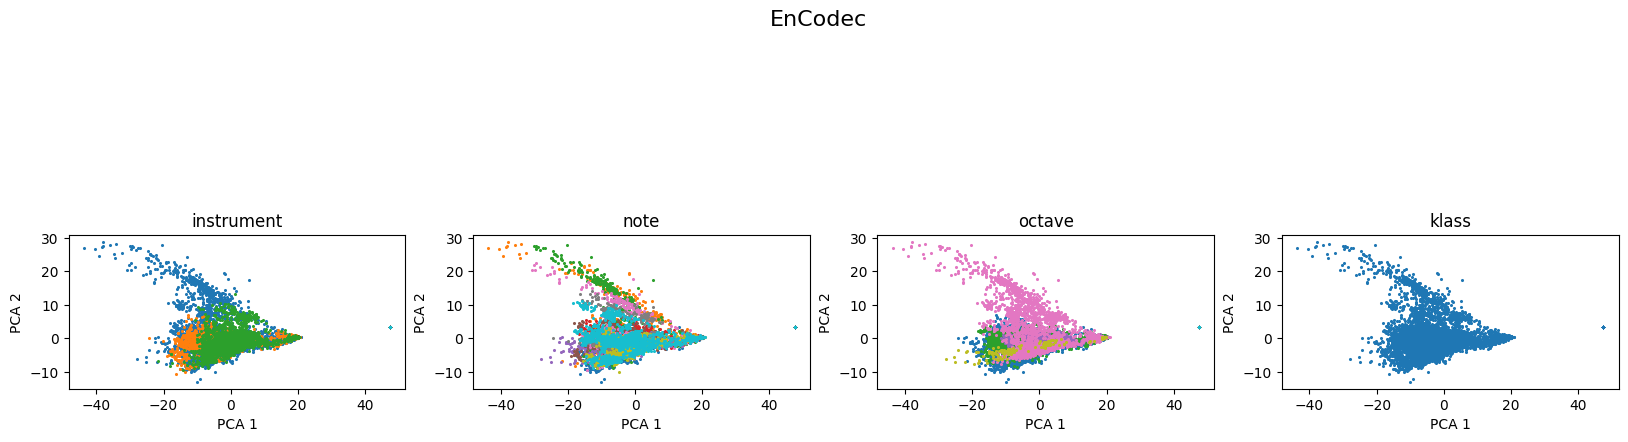

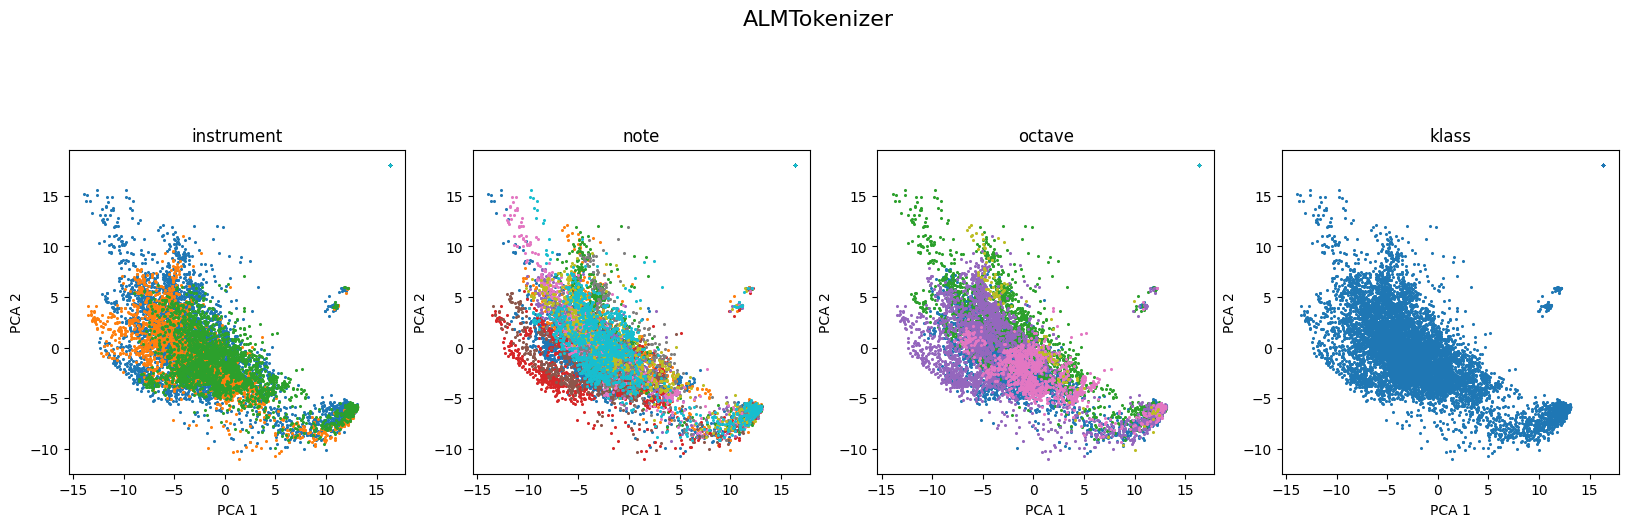

In [61]:
from sklearn.decomposition import PCA

plot_kwargs = {
    "xlabel": "PCA 1",
    "ylabel": "PCA 2",
}

attributes = ["instrument", "note", "octave", "klass"]

for method in x_subset.index.levels[0]:
    plot_kwargs["suptitles"] = f"{method}"
    x_grp = x_subset.loc[method]
    df_grp = df_subset.loc[method]
    fig = projection(x_grp, df_grp, attributes, PCA, plot_kwargs=plot_kwargs)
    fig.savefig(f"figs/{method}_pca.png", dpi=300)

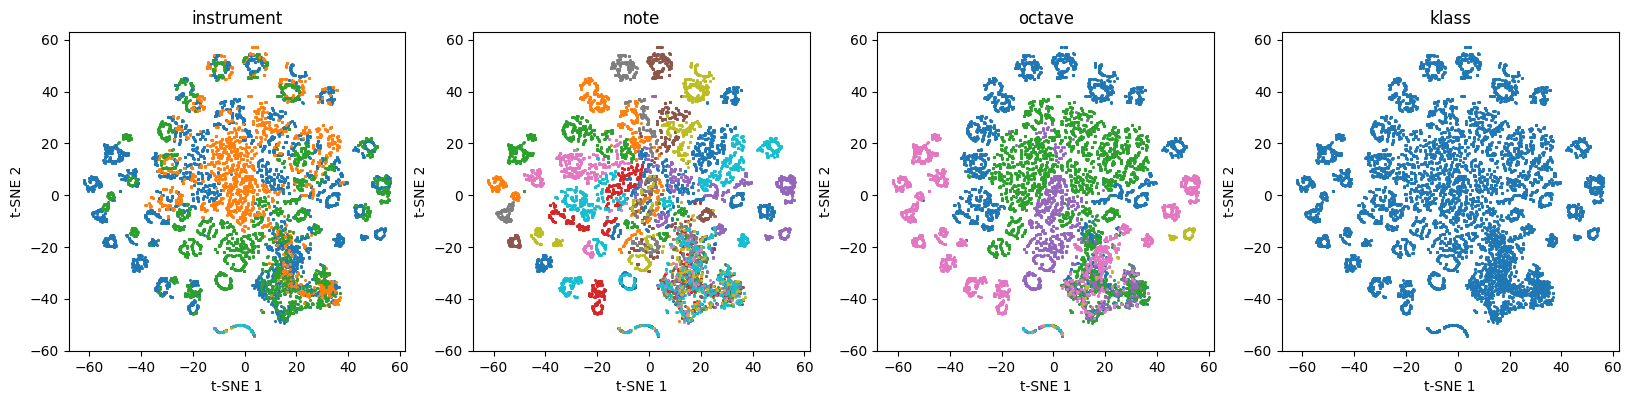

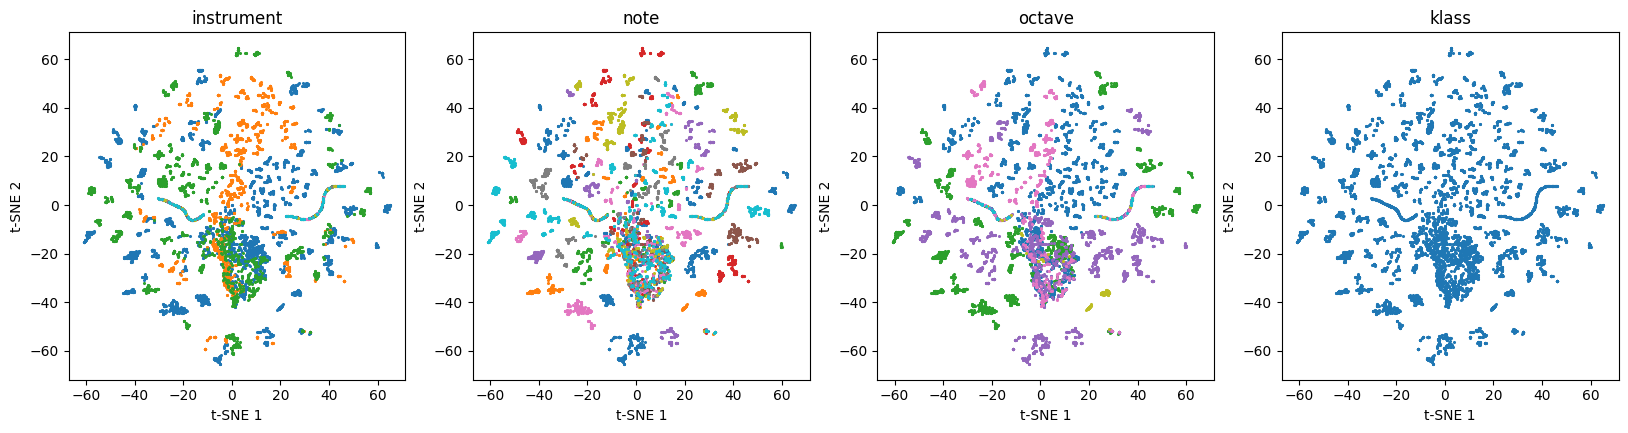

In [62]:
plot_kwargs = {
    "xlabel": "t-SNE 1",
    "ylabel": "t-SNE 2",
}

for method in x_subset.index.levels[0]:
    x_grp = x_subset.loc[method]
    df_grp = df_subset.loc[method]
    fig = projection(x_grp, df_grp, attributes, TSNE, proj_fn_kwargs={'n_jobs': -1}, plot_kwargs=plot_kwargs)
    fig.savefig(f"figs/{method}_tsne.png", dpi=300)

/tmp/ipykernel_350380/3247569012.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_350380/3247569012.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


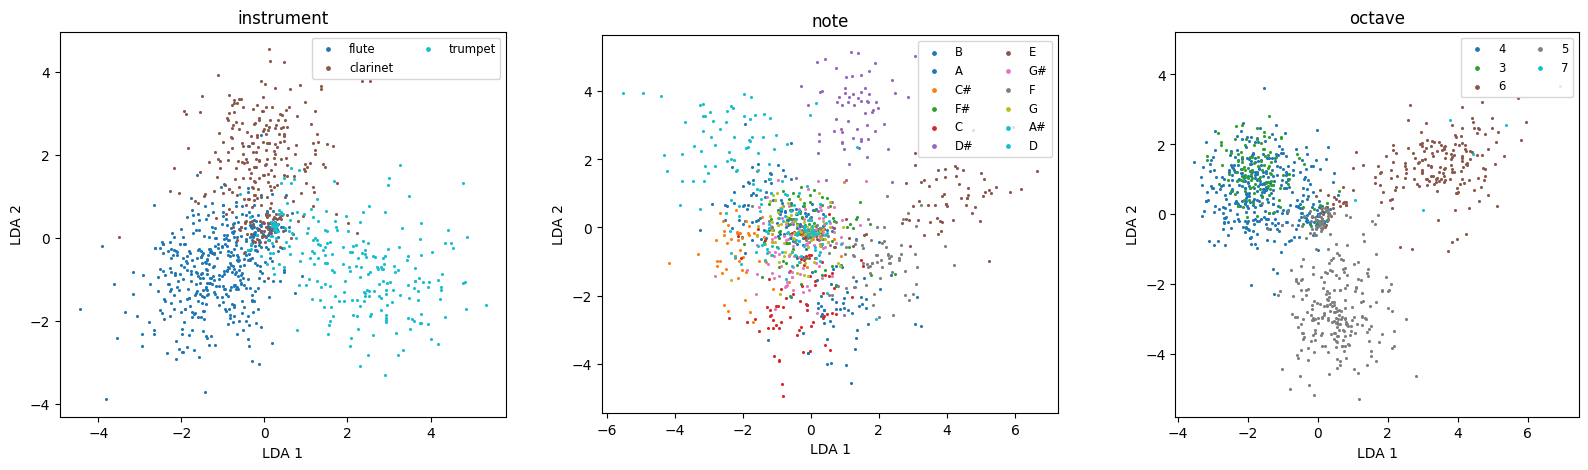

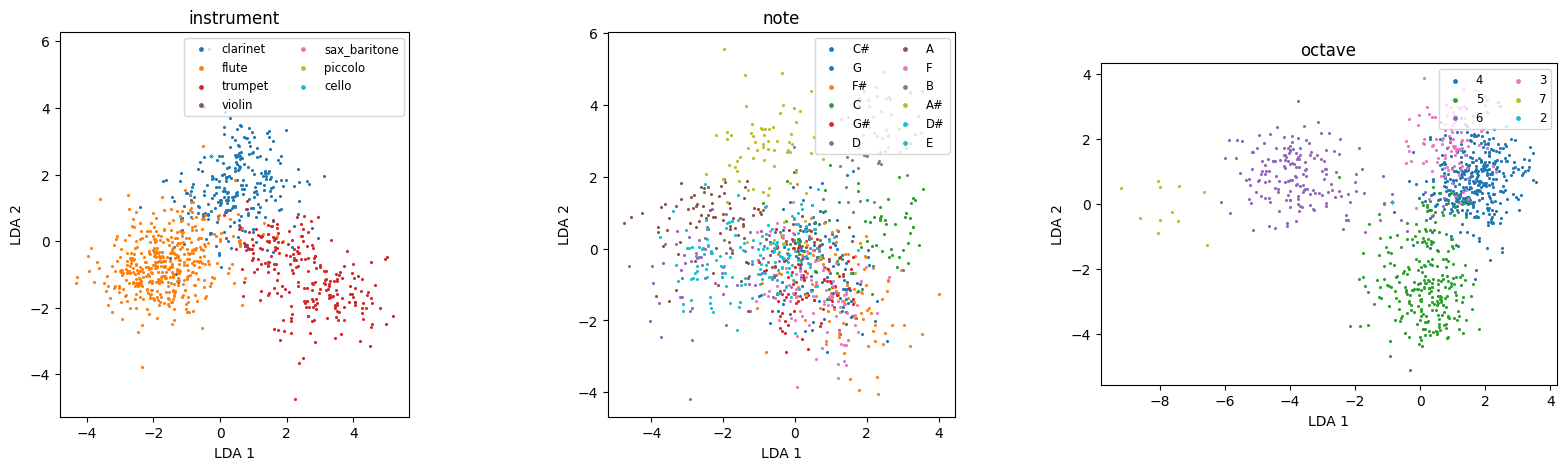

In [ ]:
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

plot_kwargs = {
    "xlabel": "LDA 1",
    "ylabel": "LDA 2",
}

for method in x_subset.index.levels[0]:
    x_grp = x_subset.loc[method]
    df_grp = df_subset.loc[method]
    projection(x_grp, df_grp, attributes[:-1], LDA, y=df_grp[attributes[:-1]], plot_kwargs=plot_kwargs)


# Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, silhouette_score
from matplotlib.ticker import MaxNLocator

def scan_k(x, true_labels, k_range):

    # Initialize lists to store metrics
    rands = list()
    mis = list()
    fmis = list()
    sil = list()
    bics = list()
    aics = list()
    ks = list()

    for k in k_range:
        kmean = KMeans(n_clusters=k)
        clusters = kmean.fit_predict(x)

        # Compute clustering metrics
        sil.append(silhouette_score(x, clusters))
        rands.append(adjusted_rand_score(true_labels, clusters))
        mis.append(normalized_mutual_info_score(true_labels, clusters))
        fmis.append(fowlkes_mallows_score(true_labels, clusters))
        ks.append(k)

    # Create a figure and axis
    fig, axs = plt.subplots(1, 1)

    # Plot the Silhouette Score
    axs.plot(ks, sil, label="Silhouette Score")

    # Plot the Adjusted Rand Index
    axs.plot(ks, rands, label="Adjusted Rand Index")

    # Plot the Mutual Information Score
    axs.plot(ks, mis, label="Mutual Information Score")

    # Plot the Fowlkes-Mallows Index
    axs.plot(ks, fmis, label="Fowlkes-Mallows Index")

    # Plot the mean of all metrics
    axs.plot(ks, np.mean([sil, rands, mis, fmis], axis=0), label="Mean")

    # Add a vertical line for the optimal number of clusters
    optim_k = min(ks) + np.argmax(np.mean([sil, rands, mis, fmis], axis=0))
    axs.axvline(optim_k, color='black', linestyle='--', label="Optimal number of clusters")

    # Add legend to the plot
    axs.legend()

    # Set the title of the plot
    axs.set_title("Clustering metrics")

    # Set the labels of the plot
    axs.set_xlabel("Number of clusters")
    axs.set_ylabel("Score")

    axs.xaxis.set_major_locator(MaxNLocator(integer=True))

    return fig, optim_k

from tqdm import trange

plot_kwargs = {
    "xlabel": "t-SNE 1",
    "ylabel": "t-SNE 2",
}

for method in ["EnCodec", "ALMTokenizer"]:
    plot_kwargs["suptitles"] = method

    # Find the best number of clusters
    fig, optim_k = scan_k(x_subset.loc[method], df_subset.loc[method]["instrument"], trange(4, 21))
    fig.savefig(f"figs/{method}_k_scan.png", dpi=300)

    # Cluster with the optimal number of clusters
    kmeans = KMeans(n_clusters=optim_k)
    clusters = kmeans.fit_predict(x_subset.loc[method])

    cluster_df = df_subset.loc[method].copy()
    cluster_df["cluster"] = clusters
    attributes = ["cluster"]
    fig = projection(x_subset.loc[method], cluster_df, attributes, proj_fn=TSNE, proj_fn_kwargs={'n_jobs': -1}, plot_kwargs=plot_kwargs)
    fig.savefig(f"figs/{method}_clusters.png", dpi=300)

  6%|▌         | 1/17 [00:09<02:24,  9.04s/it]

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 
 12%|█▏        | 2/17 [00:19<02:25,  9.72s/it]

# Linear Separability Tests

In [14]:
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def linear_separability_test(label_encoders, x, num_labels, **kwargs):
    for key in attributes:
        X_train, X_test, y_train, y_test = train_test_split(x, num_labels[key], test_size=0.2, random_state=42, stratify=num_labels[key])
        svm = SVC(**kwargs)
        svm.fit(X_train, y_train)
        accuracy = svm.score(X_test, y_test)
        print(f"SVC accuracy for {key}: {accuracy:.2f}")

svc_kwargs = {'kernel': 'linear', 'C': 1e6, 'random_state': 42, 'max_iter': 1e7}
attributes = ["instrument", "note", "octave"]
for method in ["EnCodec", "ALMTokenizer"]:
    print(f"Testing linear separability for {method}")
    linear_separability_test(attributes, x_subset.loc[method], num_labels_subset.loc[method], **svc_kwargs)
    print()

Testing linear separability for EnCodec
SVC accuracy for instrument: 0.65
SVC accuracy for note: 0.36
SVC accuracy for octave: 0.59

Testing linear separability for ALMTokenizer
SVC accuracy for instrument: 0.73
SVC accuracy for note: 0.49
SVC accuracy for octave: 0.67



# Classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

def classification_test(attributes, x, num_labels, classifier, **classifier_kwargs):
    for key in attributes:
        X_train, X_test, y_train, y_test = train_test_split(x, num_labels[key], test_size=0.2, random_state=42, stratify=num_labels[key])
        clf = classifier(**classifier_kwargs)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = clf.score(X_test, y_test)
        precision = precision_score(y_test, y_pred, average='weighted')

        print(f"Classifier accuracy for {key}: {accuracy:.2f}")
        print(f"Classifier precision for {key}: {precision:.2f}")

rf_kwargs = {'n_estimators': 100, 'random_state': 42}
attributes = ["instrument", "note", "octave"]

for method in ["EnCodec", "ALMTokenizer"]:
    print(f"Testing classification for {method}")
    classification_test(attributes, x_subset.loc[method], num_labels_subset.loc[method], RandomForestClassifier, **rf_kwargs)
    print()

Testing classification for EnCodec
Classifier accuracy for instrument: 0.71
Classifier precision for instrument: 0.73
Classifier accuracy for note: 0.60
Classifier precision for note: 0.61
Classifier accuracy for octave: 0.81
Classifier precision for octave: 0.81

Testing classification for ALMTokenizer


/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier accuracy for instrument: 0.84
Classifier precision for instrument: 0.83
Classifier accuracy for note: 0.60
Classifier precision for note: 0.61
Classifier accuracy for octave: 0.81
Classifier precision for octave: 0.82



/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Interpolation test

In [15]:

import torch
from collections import defaultdict

def create_vectors(trajectory, df, x):
    keys = list(trajectory.keys())
    Ls = [len(trajectory[k]) for k in keys]
    if len(set(Ls)) != 1:
        raise ValueError(f"All trajectory lists must be the same length; got lengths {dict(zip(keys, Ls))}")

    vectors = []
    for i in range(len(trajectory[keys[0]])):
        elem_masks = []
        for key in keys:
            elem_masks.append(df[key] == trajectory[key][i])
        reduced_mask = np.logical_and.reduce(elem_masks)
        vectors.append(torch.tensor(x[reduced_mask].mean(axis=0)).unsqueeze(0).unsqueeze(0))

    return vectors

def interpolate_latent(vectors, n):
    """
    Linearly interpolate n steps between vectors h1 and h2.

    Args:
        h1 (array-like, shape (D,)): Start latent vector.
        h2 (array-like, shape (D,)): End latent vector.
        n (int): Number of interpolation points (including h1 and h2).

    Returns:
        np.ndarray of shape (n, D): Interpolated vectors.
    """
    interpolated = []
    for i in range(len(vectors) - 1):
        h1 = np.asarray(vectors[i])
        h2 = np.asarray(vectors[i + 1])
        # 1. Create n weights from 0.0 to 1.0
        alphas = np.linspace(0.0, 1.0, num=int(n/len(vectors)))
        # 2. Compute each interpolation: (1-α)*h1 + α*h2
        interpolated.append(torch.tensor([(1.0 - a) * h1 + a * h2 for a in alphas]).squeeze(1))
    
    return torch.cat(interpolated)

trajectory1 = {
    "instrument": ["flute", "flute"],
    "note": ["E", "E"],
    "octave": ["5", "6"],
    #"klass": ["good", "good"]
}

trajectory2 = {
    "instrument": ["flute", "flute"],
    "note": ["E", "E"],
    "octave": ["5", "6"],
    #"klass": ["good", "good"]
}

trajectory3 = {
    "instrument": ["flute", "flute", "cello"],
    "note": ["E", "E", "G"],
    "octave": ["5", "6", "2"],
    #"klass": ["good", "good"]
}



from encodec import EncodecModel
encodec_dec = EncodecModel.encodec_model_24khz().decoder.to(device)

#vector_list = create_vectors(trajectory, df_subset, x_subset)

enc_n_latents = 750
alm_n_latents = enc_n_latents // (model.window_size + 1)

audios = defaultdict(dict)

trajectories = [trajectory1, trajectory2, trajectory3]
with torch.no_grad():
    for i, trajectory in enumerate(trajectories):
        # Compute EnCodec audio
        vector_list = create_vectors(trajectory, df.loc["EnCodec"], X.loc["EnCodec"])
        seq = interpolate_latent(vector_list, n=enc_n_latents)
        seq = torch.tensor(seq, dtype=torch.float32).to(device)
        seq = seq.permute(0, 2, 1)
        x_hat = encodec_dec(seq).flatten()
        audios["EnCodec"][i] = x_hat.cpu().detach().numpy()

        # Compute ALMTokenizer audio
        vector_list = create_vectors(trajectory, df.loc["ALMTokenizer"], X.loc["ALMTokenizer"])
        seq = interpolate_latent(vector_list, n=alm_n_latents)
        seq = torch.tensor(seq, dtype=torch.float32).to(model.device)
        x_hat = model.decode(seq).flatten()
        audios["ALMTokenizer"][i] = x_hat.cpu().detach().numpy()


/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/tmp/ipykernel_506959/3288152139.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  interpolated.append(torch.tensor([(1.0 - a) * h1 + a * h2 for a in alphas]).squeeze(1))
/tmp/ipykernel_506959/3288152139.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq = torch.tensor(seq, dtype=torch.float32).to(device)
/tmp/ipykernel_506959/3288152139.py:90: UserWarning: To cop

Playing audio 0 for EnCodec:


/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


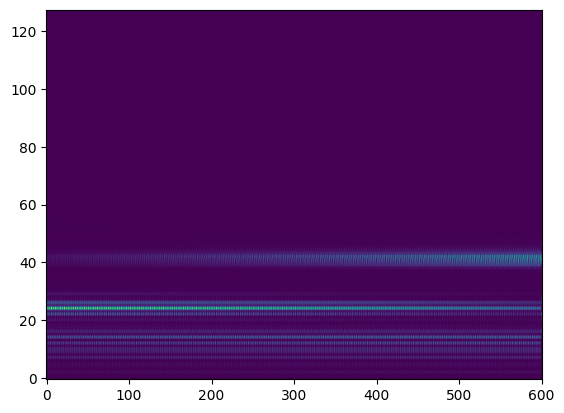

Playing audio 1 for EnCodec:


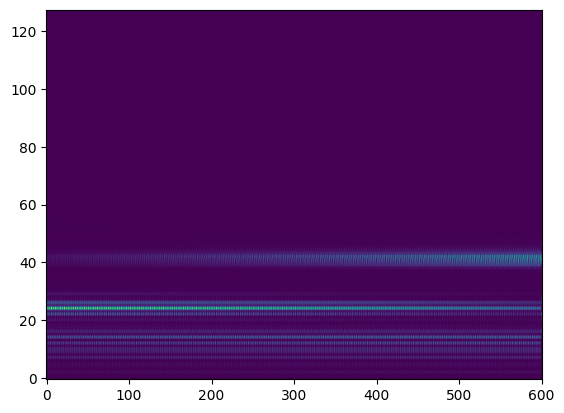

Playing audio 2 for EnCodec:


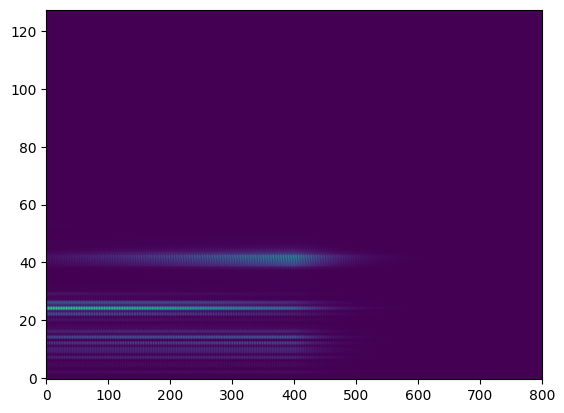

Playing audio 0 for ALMTokenizer:


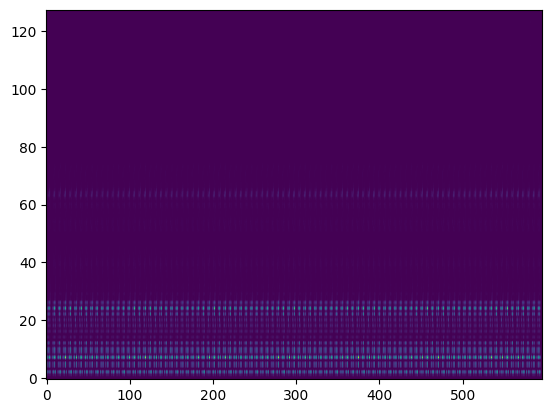

Playing audio 1 for ALMTokenizer:


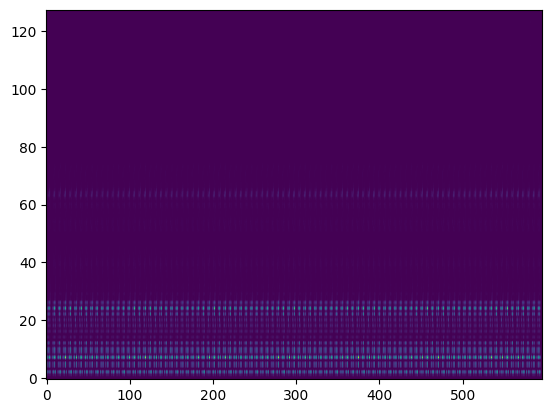

Playing audio 2 for ALMTokenizer:


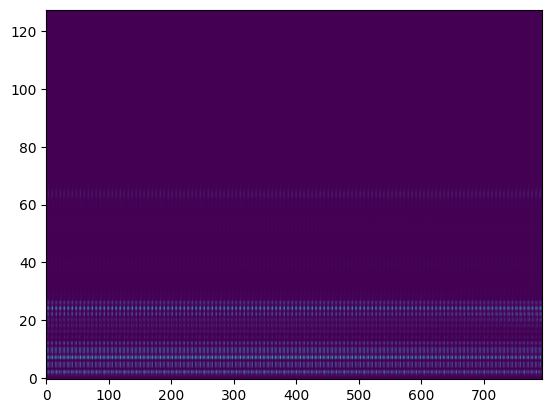

In [16]:
from IPython.display import Audio, display
from torchaudio.transforms import MelSpectrogram
import matplotlib.pyplot as plt
import torchaudio

mel_transform = MelSpectrogram()

for method, audiodict in audios.items():
    for i, audio in audiodict.items():
        print(f"Playing audio {i} for {method}:")
        display(Audio(audio, autoplay=True, rate=24000))
        # Save audio
        torchaudio.save(f"audio/{method}_trajectory_{i}.wav", torch.tensor(audio).unsqueeze(0), 24000)
        spec = mel_transform(torch.tensor(audio))
        spec = spec.squeeze(1)
        plt.imshow(spec.detach().cpu(), aspect='auto', origin='lower')
        plt.show()

# Timbre Transfer

In [38]:
df.instrument.value_counts()

flute           79461
clarinet        47472
trumpet         42701
violin            566
sax_baritone      400
cello             396
piccolo           384
sax_alto          264
sax_tenor         264
sax_soprano       264
oboe              248
Name: instrument, dtype: int64

In [46]:
import os
import torchaudio

def align_centroid(starts, dest):
    """
    Translate all starting vectors so their centroid equals dest.

    Args:
        starts (array-like, shape (M, D)): Starting vectors.
        dest   (array-like, shape (D,)):   Destination vector.

    Returns:
        np.ndarray, shape (M, D): Translated vectors whose centroid == dest.
    """

    delta = dest - starts.mean(axis=0)      # direction+amount to move the centroid
    return starts + delta  

def align_centroid_torch(starts, dest):
    X = starts.to(dtype=torch.float32)           # (M, D)
    d = dest.to(X.device, dtype=torch.float32)             # (D,)
    delta = d - X.mean(dim=(0, 1))                    # (D,)
    return X + delta                             # (M, D)


def timbre_transfer(wav_path, move_to, X, df):
    waveform, sr = torchaudio.load(wav_path, normalize=True)
    waveform = torchaudio.functional.resample(
                    waveform, orig_freq=sr, new_freq=24000
                )

    wav_tensor = torch.tensor(waveform, dtype=torch.float32).mean(dim=0, keepdim=True)[None, :].to(device)

    with torch.no_grad():
        # EnCodec
        encodec = EncodecModel.encodec_model_24khz().eval().to(device)
        encoder = encodec.encoder.to(device)
        decoder = encodec.decoder.to(device)

        frames = encoder(wav_tensor.to(device)).permute(0, 2, 1)
        destination = create_vectors(move_to, df.loc["EnCodec"], X.loc["EnCodec"])
        destination = torch.tensor(destination[0])
        new_frames = align_centroid_torch(frames, destination)
        decoder_input = new_frames.permute(0, 2, 1)
        decoder_output = decoder(decoder_input)
        wav_encodec = decoder_output.squeeze(0)
        before_encodec = encodec(wav_tensor).squeeze(0)
        display(Audio(before_encodec.flatten().cpu().detach().numpy(), rate=24000)) 
        display(Audio(wav_encodec.flatten().cpu().detach().numpy(), rate=24000))

        # ALMTokenizer
        frames = model.encode(wav_tensor.to(model.device))
        destination = create_vectors(move_to, df.loc["ALMTokenizer"], X.loc["ALMTokenizer"])
        destination = torch.tensor(destination[0])
        new_frames = align_centroid_torch(frames, destination)
        decoder_input = new_frames
        decoder_output = model.decode(decoder_input)
        wav_alm = decoder_output.squeeze(0)
        before_alm = model(wav_tensor.to(model.device))["x_hat"].squeeze(0)
        display(Audio(before_alm.flatten().cpu().detach().numpy(), rate=24000)) 
        display(Audio(wav_alm.flatten().cpu().detach().numpy(), rate=24000))
    return before_encodec, wav_encodec, before_alm, wav_alm


move_to = {
    "instrument": ["cello"],
    #"note": ["A"],
    "octave": ["3"],
    # "klass": ["good"]
    }

before_encodec, wav_encodec, before_alm, wav_alm = timbre_transfer(os.path.join("audio", "speech-male.wav"), move_to, X, df)
torchaudio.save("audio/before_encodec_1.wav", before_encodec, 24000)
torchaudio.save("audio/after_encodec_1.wav", wav_encodec, 24000)
torchaudio.save("audio/before_alm_1.wav", before_alm, 24000)
torchaudio.save("audio/after_alm_1.wav", wav_alm, 24000)

before_encodec, wav_encodec, before_alm, wav_alm = timbre_transfer(os.path.join("audio", "speech-female.wav"), move_to, X, df)
torchaudio.save("audio/before_encodec_2.wav", before_encodec, 24000)
torchaudio.save("audio/after_encodec_2.wav", wav_encodec, 24000)
torchaudio.save("audio/before_alm_2.wav", before_alm, 24000)
torchaudio.save("audio/after_alm_2.wav", wav_alm, 24000)

/tmp/ipykernel_506959/4075688798.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wav_tensor = torch.tensor(waveform, dtype=torch.float32).mean(dim=0, keepdim=True)[None, :].to(device)
/tmp/ipykernel_506959/4075688798.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  destination = torch.tensor(destination[0])


/tmp/ipykernel_506959/4075688798.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  destination = torch.tensor(destination[0])


In [25]:
df["instrument"].unique()

array(['flute', 'trumpet', 'violin', 'cello', 'clarinet', 'sax_alto',
       'sax_tenor', 'sax_baritone', 'sax_soprano', 'oboe', 'piccolo'],
      dtype=object)

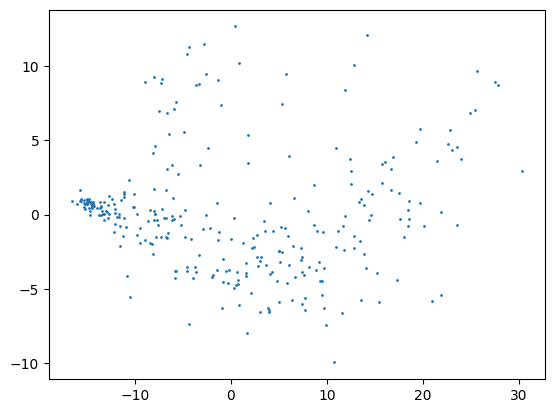

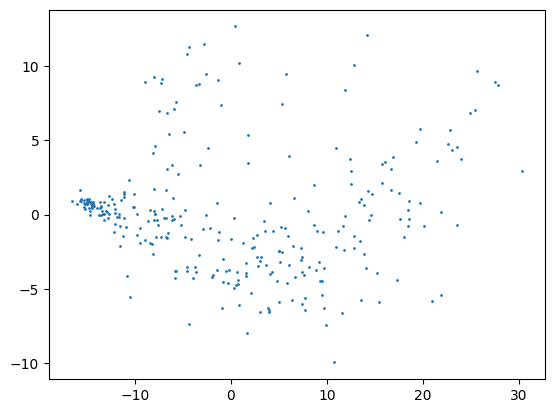

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
coords = pca.fit_transform(new_frames.squeeze())
plt.scatter(coords[:, 0], coords[:, 1], s=1)
plt.show()
pca = PCA()
coords = pca.fit_transform(frames.squeeze())
plt.scatter(coords[:, 0], coords[:, 1], s=1)